Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime
import datetime as dt
import copy
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

In [16]:
from data_setup import copy_images_to_folders
from image_check import imshow
from model import CustomEfficientNetB0, validate_model, train_model, plot_metrics, visualize_model
from uncertainty_metrics import calculate_risks, process_labels, calculate_and_append_risks, calculate_and_append_risks_by_class, calculate_softmax_uncertainties, calculate_top2_softmax_uncertainties, calculate_random_uncertainties, calculate_mc_dropout_uncertainties_by_sample, calculate_mc_dropout_uncertainties_by_class, calculate_variance_uncertainties, calculate_variational_ratio_uncertainties, calculate_entropy_uncertainties, calculate_predictive_entropy_uncertainties, calculate_mutual_information_uncertainties, smooth_calcs, calculate_aurc, plot_risk_coverage, process_uncertainties

In [3]:
# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

# set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Sort data into folders based on class

In [4]:
csv_path = 'data/ISIC_2019_Training_GroundTruth.csv'
image_folder = 'data/ISIC_2019_Resized'
output_folder = 'data/ISIC_Sorted'

copy_images_to_folders(csv_path, image_folder, output_folder)

print("done")

done


Split data into training, validation and test

In [4]:
# declare variables for model creation
input_folder = 'data/ISIC_Sorted'  # This is the folder containing class subdirectories
output_folder = 'data/data_subset'  # The desired output folder for "training" and "validation" folders
sample_limit=None #None or a number up to 12875
train_ratio=0.334
val_ratio=0.333
test_ratio=0.333

if train_ratio+val_ratio+test_ratio != 1:
    print("invalid data ratios")

set_batch_size=64

#sample numbers by class copied here for reference
#MEL	NV	    BCC	    AK	 BKL	DF	VASC  SCC	UNK
#4522	12875	3323	867	 2624	239	253	  628	0

print("done")

done


In [5]:
training_folder = os.path.join(output_folder, 'train')
validation_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

In [7]:
# Remove existing "training" and "validation" folders if they exist
shutil.rmtree(training_folder, ignore_errors=True)
shutil.rmtree(validation_folder, ignore_errors=True)
shutil.rmtree(test_folder, ignore_errors=True)

# Create the "training" and "validation" folders
os.makedirs(training_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# generate list of class names from the folder structure
class_names = [class_name for class_name in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, class_name))]

print("done")

done


In [8]:
# Iterate through each class folder
for class_name in os.listdir(input_folder):
    class_folder_input = os.path.join(input_folder, class_name)
    if os.path.isdir(class_folder_input):
        # Get a list of all images in the class folder
        images = [img for img in os.listdir(class_folder_input) if img.endswith('.jpg')]
        
        # Limit the number of samples if sample_limit is provided
        if sample_limit is not None:
            images = images[:sample_limit]

        # Randomly shuffle the list of images
        np.random.seed(42)
        np.random.shuffle(images)

        # Calculate the number of samples for training and validation
        class_size = len(images)
        num_training_samples = int(class_size * train_ratio)
        num_val_samples = int(class_size * val_ratio)
        num_test_samples = int(class_size * test_ratio)

        # Create the class subfolders within the output folders
        class_folder_training = os.path.join(training_folder, class_name)
        class_folder_validation = os.path.join(validation_folder, class_name)
        class_folder_test = os.path.join(test_folder, class_name)
        os.makedirs(class_folder_training, exist_ok=True)
        os.makedirs(class_folder_validation, exist_ok=True)
        os.makedirs(class_folder_test, exist_ok=True)

        # Copy images to the training folder
        for image_name in images[:num_training_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_training)
        # Copy images to the validation folder
        for image_name in images[num_training_samples:num_training_samples + num_val_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_validation)
        # Copy images to the test folder
        for image_name in images[num_training_samples + num_val_samples:]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_test)

print("done")

done


In [9]:
#remove unknown folder as no samples
shutil.rmtree("data/data_subset/train/UNK", ignore_errors=True)
shutil.rmtree("data/data_subset/val/UNK", ignore_errors=True)
shutil.rmtree("data/data_subset/test/UNK", ignore_errors=True)

In [6]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=360),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [7]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=set_batch_size, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#print checks to see if the values are the same - if yes then can remove the assignment here
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print(f"file: ", class_names)

file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


show sample images

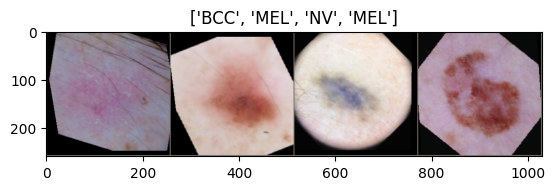

In [8]:
# Specify the number of images to display
num_images = 4

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Select a subset of images
inputs_subset = inputs[:num_images]
classes_subset = classes[:num_images]

# Make a grid from the subset
out = torchvision.utils.make_grid(inputs_subset)

imshow(out, title=[class_names[x] for x in classes_subset])

temporary fix for efficientnet weights issue

In [9]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model fitting configuration

In [10]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_epoch = 1

# Initialize the custom model with dropout
model_ft = CustomEfficientNetB0(num_classes=num_classes, dropout_prob=0.4)

# Move the model to the specified device (e.g., GPU or CPU)
model_ft = model_ft.to(device)

# Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Use the Adam optimizer for training
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define a learning rate scheduler to decay the learning rate
# by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [11]:
# Calculate class weights
class_weights = {}
total_samples = 0

# Initialize class counts dictionary
class_counts = {class_idx: 0 for class_idx in range(len(image_datasets['train'].classes))}

# Iterate over training dataloader to count samples for each class
for inputs, labels in dataloaders['train']:
    for label in labels:
        class_counts[label.item()] += 1
        total_samples += 1

# Calculate class weights using the formula
for class_idx, count in class_counts.items():
    class_weights[class_idx] = (1 / count) * (total_samples / len(class_counts))

# Print class weights
print("Class Weights:", class_weights)

# Define the loss function (cross-entropy loss) with class weights
criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float)).to(device)

Class Weights: {0: 3.6574394463667823, 1: 0.9531109107303877, 2: 1.20662100456621, 3: 13.379746835443038, 4: 0.7, 5: 0.2458139534883721, 6: 5.057416267942584, 7: 12.583333333333332}


In [12]:
# Load the checkpoint
checkpoint = torch.load('saved_models/checkpoint.pth.tar')

# Load model state_dict
model_ft.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer state_dict
optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])

# Load scheduler state_dict
exp_lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Retrieve other variables
best_combined_metric = checkpoint['best_combined_metric']
best_val_loss = checkpoint['best_val_loss']
best_val_acc = checkpoint['best_val_acc']
best_epoch = checkpoint['best_epoch']
train_losses = checkpoint['train_losses']
train_accuracies = checkpoint['train_accuracies']
val_losses = checkpoint['val_losses']
val_accuracies = checkpoint['val_accuracies']

In [ ]:
#train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, train_losses, train_accuracies, val_losses, val_accuracies, best_epoch, num_epochs=2, num_val_mc_samples=10, loss_weight=1, acc_weight=0, num_classes=num_classes)
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, train_losses, train_accuracies, val_losses, val_accuracies, best_epoch, num_epochs=45, num_val_mc_samples=100, loss_weight=1, acc_weight=0, num_classes=num_classes, save_dir="saved_models", resume_training=True)

Epoch 1/50 - 2024-03-12 13:46:14
----------
Train Loss: 0.2217, Train Acc: 0.3671

Val Loss: 0.2393, Val Acc: 0.5190

Epoch 2/50 - 2024-03-12 14:12:54
----------
Train Loss: 0.1989, Train Acc: 0.4499

Val Loss: 0.2713, Val Acc: 0.5181

Epoch 3/50 - 2024-03-12 16:29:09
----------
Train Loss: 0.1847, Train Acc: 0.4816

Val Loss: 0.2132, Val Acc: 0.5081

Epoch 4/50 - 2024-03-12 18:20:59
----------
Train Loss: 0.1671, Train Acc: 0.5304

Val Loss: 0.2317, Val Acc: 0.5266

Epoch 5/50 - 2024-03-12 19:46:10
----------
Train Loss: 0.1689, Train Acc: 0.5277

Val Loss: 0.2089, Val Acc: 0.5098

Epoch 6/50 - 2024-03-12 20:58:44
----------
Train Loss: 0.1568, Train Acc: 0.5556



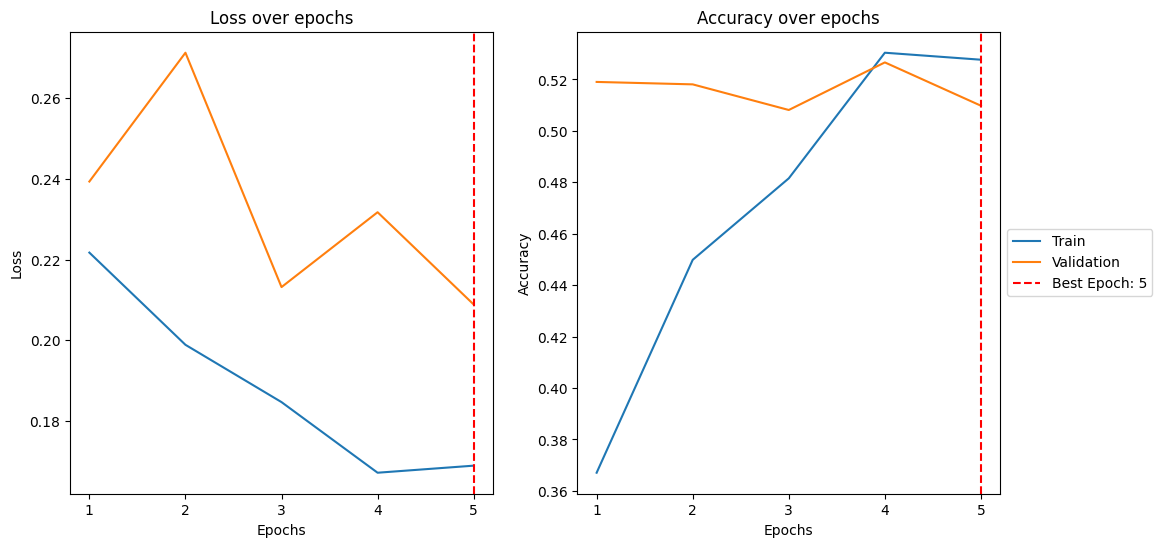

In [13]:
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, best_epoch)

visualise trained model

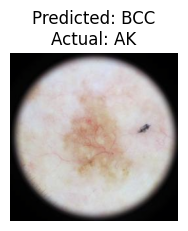

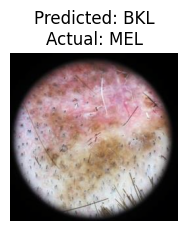

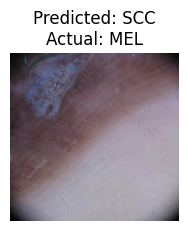

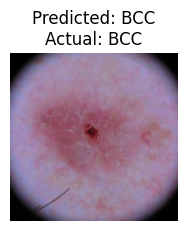

In [14]:
visualize_model(model_ft, dataloaders['val'], device, class_names, num_images=4)

In [19]:
# Lists to store results
risks_list = []
labels_list = []

risks_list_by_class = [[] for _ in range(len(class_names))]
labels_list_by_class = [[] for _ in range(len(class_names))]

uncertainty_functions = [
    (calculate_softmax_uncertainties, "Softmax Response"),
    (calculate_top2_softmax_uncertainties, "Top2 Softmax Difference"),
    (calculate_random_uncertainties, "Random Uncertainties"),
    (calculate_mc_dropout_uncertainties_by_sample, "MCD By Sample", 100),
    (calculate_mc_dropout_uncertainties_by_class, "MCD By Class", 100),
    (calculate_variance_uncertainties, "Variance"),
    (calculate_variational_ratio_uncertainties, "Variational Ratio"),
    (calculate_entropy_uncertainties, "Entropy"),
    (calculate_predictive_entropy_uncertainties, "Predictive Entropy", 100),
    (calculate_mutual_information_uncertainties, "Mutual Information")
]

# Iterate over each uncertainty calculation function
for function, name, *args in uncertainty_functions:
    # Call the process_uncertainties function with the current uncertainty calculation function and parameters
    process_uncertainties(risks_list, labels_list, risks_list_by_class, labels_list_by_class, model_ft, dataloaders['test'], class_names, device, function, name, *args)

print("Done")

Softmax Response processed
Top2 Softmax Difference processed
Done


In [ ]:
description_list = [
    "Softmax Response measures the model's confidence in its predictions based on the softmax probabilities.",
    "Top2 Softmax Difference measures the uncertainty by calculating the difference between the top two softmax probabilities",
    "Random Uncertainties assigns random uncertainty values to each prediction, providing a baseline comparison for uncertainty estimation methods.",
    "MCD By Sample utilizes Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout.",
    "MCD By Class employs Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout for each class.",
    "Variance calculates uncertainty by computing the variance of softmax probabilities across classes for each prediction.",
    "Variational Ratio calculates uncertainty by computing the ratio of the maximum softmax probability (mode probability) to the maximum probability among other classes for each prediction.",
    "Entropy calculates uncertainty by measuring the entropy of softmax probabilities for each prediction.",
    "Predictive Entropy estimates uncertainty by averaging the entropy of softmax probabilities across multiple samples generated with dropout.",
    "Mutual Information computes uncertainty by measuring the mutual information between the model's softmax probabilities and a uniform distribution."
]

for description in description_list:
    print(f"- {description}")

print(
"""
- Risk = 1 - Accuracy, where Accuracy is the mean accuracy (normalised) over the samples included in the Coverage.
- Coverage is the normalised number of samples over the total samples. Coverage decreases as the most uncertain samples are removed.
- Area Under Risk Coverage (AURC) is the area under the Risk Coverage curve.

- Classes:
    - Melanoma (MEL)
    - Melanocytic nevus (NV)
    - Basal cell carcinoma (BCC)
    - Actinic keratosis (AK)
    - Benign keratosis (BKL) 
        [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
    - Dermatofibroma (DF)
    - Vascular lesion (VASC)
    - Squamous cell carcinoma (SCC)
    - None of the others (UNK)
"""
)

All Classes: 8444 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Softmax Response            	0.2832			0.3066
Top2 Softmax Difference     	0.2869			0.3103


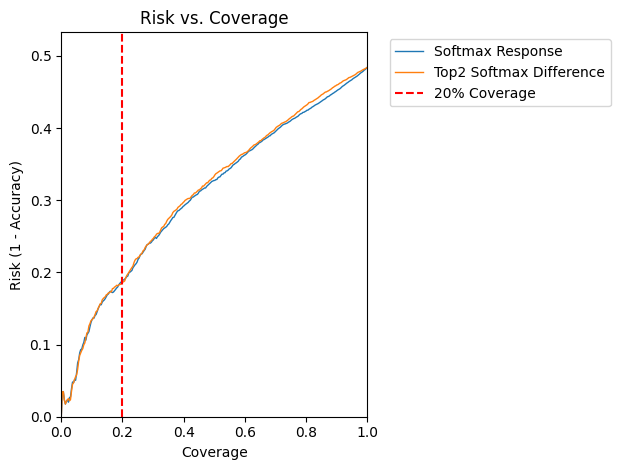

AK: 290 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Top2 Softmax Difference     	0.7081			0.9112
Softmax Response            	0.7087			0.9118


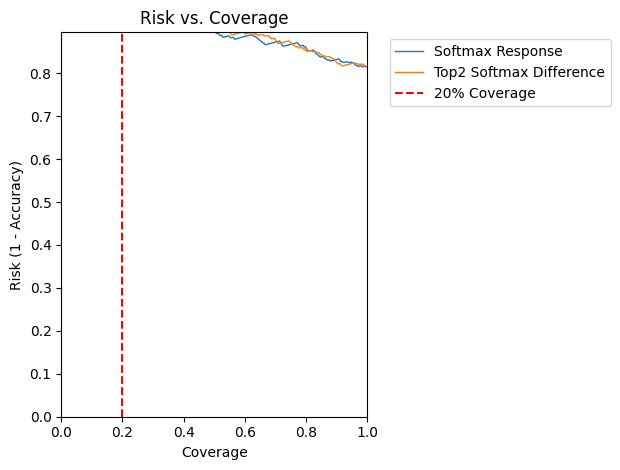


BCC: 1108 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Softmax Response            	0.1758			0.2073
Top2 Softmax Difference     	0.1784			0.2112


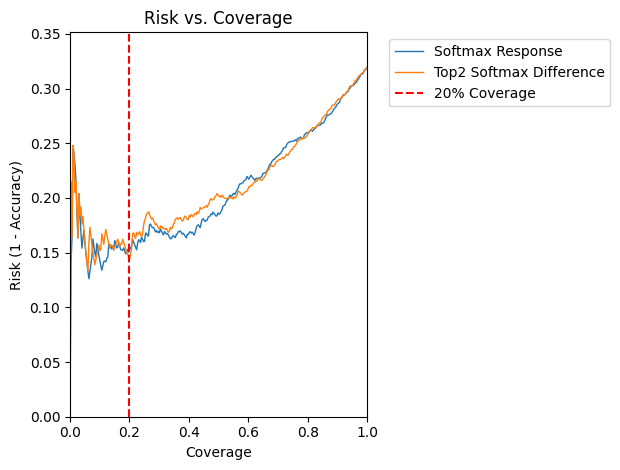


BKL: 875 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Top2 Softmax Difference     	0.3015			0.3363
Softmax Response            	0.3115			0.3489


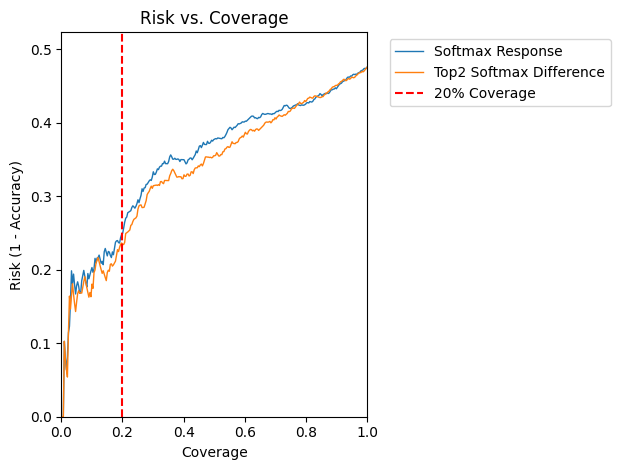


DF: 81 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Top2 Softmax Difference     	0.3756			0.4062
Softmax Response            	0.3831			0.4158


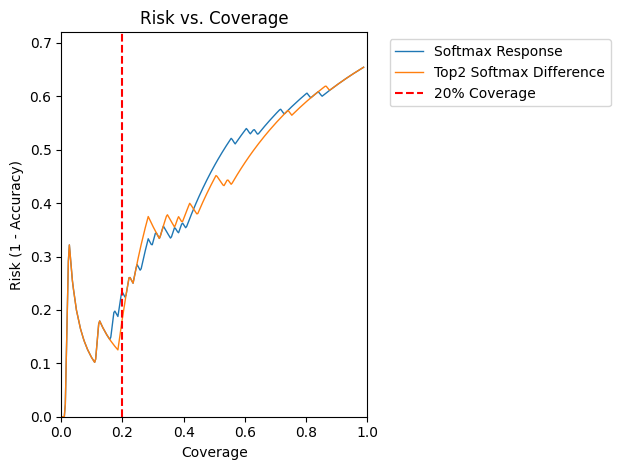


MEL: 1507 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Softmax Response            	0.2642			0.2760
Top2 Softmax Difference     	0.2684			0.2806


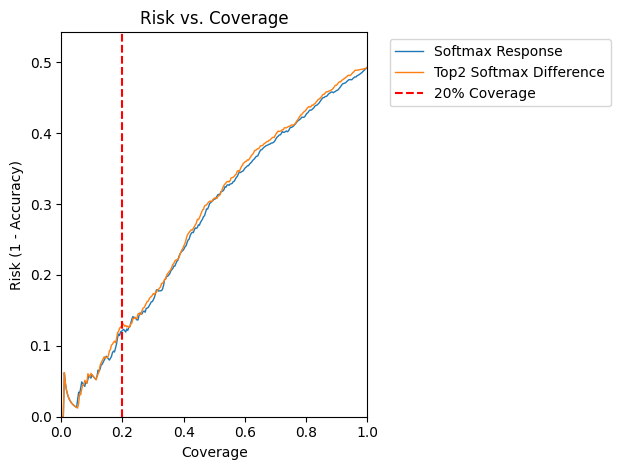


NV: 4288 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Softmax Response            	0.2693			0.2905
Top2 Softmax Difference     	0.2775			0.2986


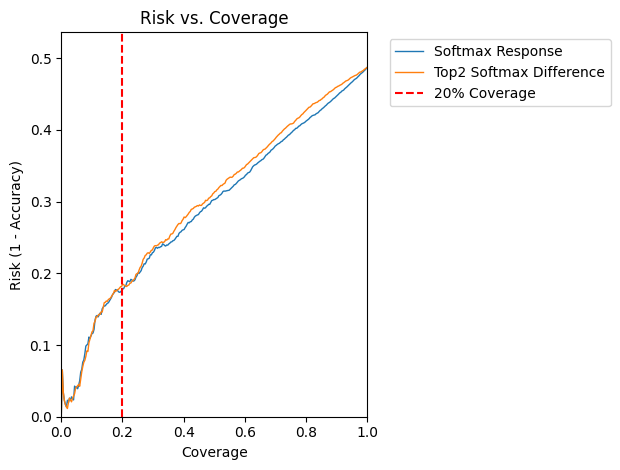


SCC: 210 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Top2 Softmax Difference     	0.6058			0.8000
Softmax Response            	0.6065			0.8031


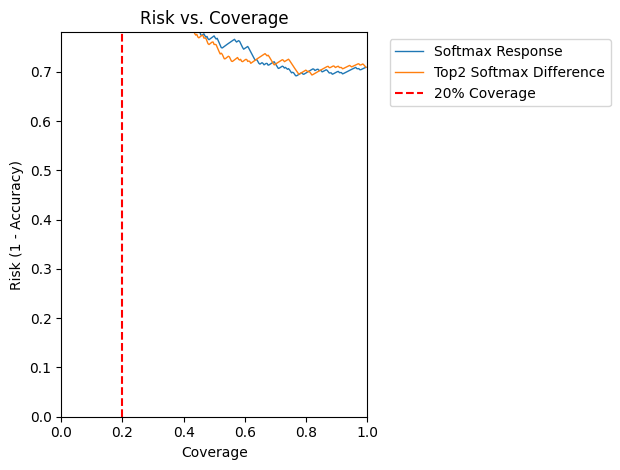


VASC: 85 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Softmax Response            	0.3412			0.4028
Top2 Softmax Difference     	0.3542			0.4199


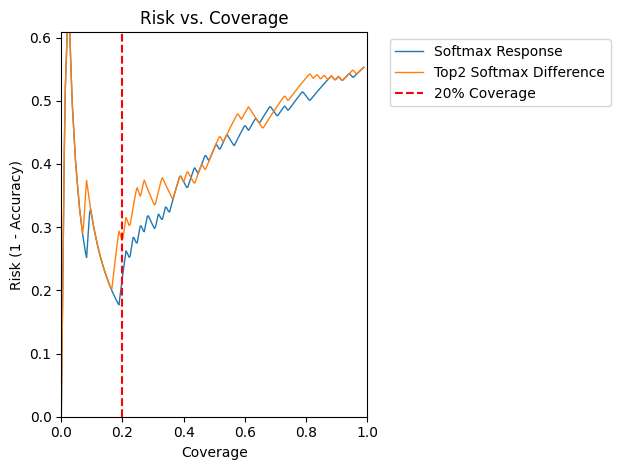


done


In [20]:
print(f"All Classes: {len(risks_list[0])} samples")
x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(risks_list[0])
calculate_aurc(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage)
# Plot the risk coverage curve
plot_risk_coverage(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage)

for i in range(len(class_names)):
    print(f"{class_names[i]}: {len(risks_list_by_class[i][0])} samples")
    x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(risks_list_by_class[i][0])
    calculate_aurc(risks_list_by_class[i], labels_list_by_class[i], x_smooth_percentage_interp, x_smooth_percentage)
    # Plot the risk coverage curve
    plot_risk_coverage(risks_list_by_class[i], labels_list_by_class[i], x_smooth_percentage_interp, x_smooth_percentage)
    print()
    
print("done")